# Информационная безопасность

Компания онлайн-сервис с высоким уровнем входящего трафика имеет специализированный отдел безопасности, который занимается фильтрацией и анализом трафика. Сотрудники этого отдела обратились за помощью в автоматизации выявления аномального и злонамеренного трафика. Ваша задача - разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный, включая следующие типы атак: DDoS, SQL-инъекции, брутфорс, вредоносные программы и т.д.

___

**Задача:**

- Разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный. При этом модель должна работать максимально качественно, так как цена ошибки может быть очень высока.
- Оценить качество модели по различным метрикам классификации: precision, recall, f1_score, accuracy.

___

Целевым признаком является столбец `Label`. Значение **BENIGN** - это нормальный трафик, а остальные 14 значений - это различные типы злонамеренного трафика.

## Загрузка данных

### Импорт используемых библиотек

In [1]:
import pandas as pd
import numpy as np
import re

import ydata_profiling

import matplotlib.pyplot as plt
import seaborn as sns

import phik
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from IPython.core.display import display, HTML

pd.set_option('display.max_columns', None)

display(HTML("<style>.container { width:80% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

C:\Users\user\AppData\Local\Temp\ipykernel_14696\4234547035.py:23: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Чтение файла

In [3]:
df = pd.read_csv('network_traffic_data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             539616 non-null  int64  
 1    Flow Duration                539616 non-null  int64  
 2    Total Fwd Packets            539616 non-null  int64  
 3    Total Backward Packets       539616 non-null  int64  
 4   Total Length of Fwd Packets   539616 non-null  int64  
 5    Total Length of Bwd Packets  539616 non-null  int64  
 6    Fwd Packet Length Max        539616 non-null  int64  
 7    Fwd Packet Length Min        539616 non-null  int64  
 8    Fwd Packet Length Mean       539616 non-null  float64
 9    Fwd Packet Length Std        539616 non-null  float64
 10  Bwd Packet Length Max         539616 non-null  int64  
 11   Bwd Packet Length Min        539616 non-null  int64  
 12   Bwd Packet Length Mean       539616 non-nul

Оптимизируем память нашего датасета, форматируя столбцы из 64-битного типа в 16-битный

In [5]:
float64_features = df.select_dtypes(include='float64').columns.to_list()
int64_features = df.select_dtypes(include='int64').columns.to_list()

df[float64_features] = df[float64_features].astype('float16')
df[int64_features] = df[int64_features].astype('int16')

Посмотрим на данные

In [6]:
def print_dataset_info(df):
    print("\nПервые 5 строк датасета:")
    display(df.head())
    #print("\nСтатистическое описание данных:")
    #display(df.describe())
    print("\nКоличество пропусков:")
    display(df.isna().sum().sum())

In [7]:
print_dataset_info(df)


Первые 5 строк датасета:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,-24950,3,1,12,0,6,0,4.000000,3.464844,0,0,0.0,0.0,2.189453,0.729980,inf,inf,3316,101,-24950,inf,inf,3316,-28266,0,0.0,0.0,0,0,0,0,0,0,72,32,0.547363,0.182495,0,6,2.400391,3.287109,10.796875,0,0,0,1,0,0,0,0,0,3.000,4.000000,0.0,72,0,0,0,0,0,0,3,12,1,0,8192,-22756,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,-8919,9,10,703,3950,267,0,78.125000,103.312500,1448,0,395.0,587.5,6536.000000,26.687500,39552.000,50144.00,-10571,1,26477,inf,inf,19006,230,27050,inf,inf,3228,1,0,0,0,0,296,328,12.640625,14.046875,0,1448,232.625000,442.750000,inf,0,0,0,1,0,0,0,0,1,244.875,78.125000,395.0,296,0,0,0,0,0,0,9,703,10,3950,29200,252,4,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,22326,2,2,80,224,40,40,40.000000,0.000000,112,112,112.0,0.0,1982.000000,26.078125,51136.000,inf,22319,3,3,3.0,0.0,3,3,4,4.0,0.0,4,4,0,0,0,0,40,40,13.039062,13.039062,40,112,68.812500,39.437500,1555.000000,0,0,0,0,0,0,0,0,1,86.000,40.000000,112.0,40,0,0,0,0,0,0,2,80,2,224,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,-7876,1,1,46,128,46,46,46.000000,0.000000,128,128,128.0,0.0,3018.000000,34.687500,57664.000,0.00,-7876,-7876,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,17.343750,17.343750,46,128,73.312500,47.343750,2242.000000,0,0,0,0,0,0,0,0,1,110.000,46.000000,128.0,20,0,0,0,0,0,0,1,46,1,128,-1,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.335938,14.437500,6,6,6.0,0.0,63872.000000,5216.000000,255.625,394.25,710,3,713,356.5,500.0,710,3,0,0.0,0.0,0,0,0,0,0,0,60,20,3912.000000,1304.000000,6,31,11.000000,11.179688,125.000000,0,0,0,0,1,0,0,0,0,13.750,14.335938,6.0,60,0,0,0,0,0,0,3,43,1,6,1017,0,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN



Количество пропусков:


488

В данных имеются бесконечные значения, которые не дают оценить статистику данных

Посмотрим на респределение классов в целевом признаке

In [8]:
df['Label'].value_counts(normalize=True) * 100

BENIGN                        44.476072
DoS Hulk                      21.491950
PortScan                      14.762350
DDoS                          11.928112
DoS GoldenEye                  1.907468
FTP-Patator                    1.471046
SSH-Patator                    1.092814
DoS slowloris                  1.074097
DoS Slowhttptest               1.019058
Bot                            0.364333
Web Attack � Brute Force       0.279273
Web Attack � XSS               0.120827
Infiltration                   0.006671
Web Attack � Sql Injection     0.003892
Heartbleed                     0.002038
Name: Label, dtype: float64

Около 45% от всего трафика является нормальным, остальной - вредоносный.

## Предобработка

Переведем названия столбцов в змеинный регистр

In [9]:
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

Подсчет статистики не выполнился, т.к. имеются бесконечные значения. Найдем признаки с этими значениями

In [10]:
columns_with_infinity = df.columns[df.isin([np.inf, -np.inf]).any()]
columns_with_infinity

Index(['flow_bytes/s', 'flow_packets/s', 'flow_iat_mean', 'flow_iat_std',
       'fwd_iat_mean', 'fwd_iat_std', 'bwd_iat_mean', 'bwd_iat_std',
       'fwd_packets/s', 'bwd_packets/s', 'packet_length_variance',
       'active_mean', 'active_std', 'idle_mean', 'idle_std'],
      dtype='object')

Заменим положительные бесконечности на максимальные значения...

In [11]:
df.replace(np.inf, np.nan, inplace=True)

max_values = df.max()
df.fillna(max_values, inplace=True)

... отрицательные - на минимальные.

In [12]:
df.replace(-np.inf, np.nan, inplace=True)

min_values = df.min()
df.fillna(min_values, inplace=True)

In [13]:
df.isna().sum().sum()

0

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
destination_port,539616.0,-391.477656,5788.539066,-32768.000000,53.000000,80.000000,259.0000,32767.0
flow_duration,539616.0,1075.061201,15011.004092,-32768.000000,-4004.250000,58.000000,7505.2500,32767.0
total_fwd_packets,539616.0,5.512726,69.155087,1.000000,1.000000,2.000000,6.0000,19449.0
total_backward_packets,539616.0,5.135350,88.388878,-359.000000,1.000000,2.000000,5.0000,28467.0
total_length_of_fwd_packets,539616.0,320.064896,1372.159056,-32629.000000,2.000000,44.000000,319.0000,32741.0
total_length_of_bwd_packets,539616.0,3077.316749,5451.788190,-32760.000000,0.000000,98.000000,6301.2500,32752.0
fwd_packet_length_max,539616.0,169.449966,560.533869,0.000000,2.000000,23.000000,272.0000,24820.0
fwd_packet_length_min,539616.0,11.855382,60.961661,0.000000,0.000000,0.000000,6.0000,2065.0
fwd_packet_length_mean,539616.0,NaN,NaN,0.000000,2.000000,11.218750,48.5625,5940.0
fwd_packet_length_std,539616.0,NaN,NaN,0.000000,0.000000,0.000000,91.6875,7048.0


## Создание признаков

Определимся с определениями признаков

- destination_port - порт назначения
- flow_duration - длительность потока
- total_fwd_packets - общее количество пересылаемых пакетов вперед
- total_backward_packets - общее количество пересылаемых пакетов назад
- total_length_of_fwd_packets - общая длина пересылаемых вперед пакетов
- total_length_of_bwd_packets - общая длина пересылаемых назад пакетов
- fwd_packet_length_max - максимальная длина вперед пересылаемого пакета
- fwd_packet_length_min - минимальная длина вперед пересылаемого пакета
- fwd_packet_length_mean - средняя длина вперед пересылаемого пакета
- fwd_packet_length_std - стандартное отклонение длины вперед пересылаемого пакета
- bwd_packet_length_max - максимальная длина назад пересылаемого пакета
- bwd_packet_length_min - минимальная длина назад пересылаемого пакета
- bwd_packet_length_mean - средняя длина назад пересылаемого пакета
- bwd_packet_length_std - стандартное отклонение длины назад пересылаемого пакета
- flow_bytes/s - байтов в секунду в потоке
- flow_packets/s - пакетов в секунду в потоке
- flow_iat_mean - среднее время между пакетами в потоке
- flow_iat_std - стандартное отклонение времени между пакетами в потоке
- flow_iat_max - максимальное время между пакетами в потоке
- flow_iat_min - минимальное время между пакетами в потоке
- fwd_iat_total - общее время между пересылаемыми пакетами вперед
- fwd_iat_mean - среднее время между пересылаемыми пакетами вперед
- fwd_iat_std - стандартное отклонение времени между пересылаемыми пакетами вперед
- fwd_iat_max - максимальное время между пересылаемыми пакетами вперед
- fwd_iat_min - минимальное время между пересылаемыми пакетами вперед
- bwd_iat_total - общее время между пакетами назад
- bwd_iat_mean - среднее время между пакетами назад
- bwd_iat_std - стандартное отклонение времени между пакетами назад
- bwd_iat_max - максимальное время между пакетами назад
- bwd_iat_min - минимальное время между пакетами назад
- fwd_psh_flags - количество установленных флагов PSH в передних пакетах
- bwd_psh_flags - количество установленных флагов PSH в задних пакетах
- fwd_urg_flags - количество установленных флагов URG в передних пакетах
- bwd_urg_flags - количество установленных флагов URG в задних пакетах
- fwd_header_length - общая длина заголовков в передних пакетах
- bwd_header_length - общая длина заголовков в задних пакетах
- fwd_packets/s - количество передних пакетов в секунду
- bwd_packets/s - количество задних пакетов в секунду
- min_packet_length - минимальная длина пакета
- max_packet_length - максимальная длина пакета
- packet_length_mean - средняя длина пакета
- packet_length_std - стандартное отклонение длины пакета
- packet_length_variance - дисперсия длины пакета
- fin_flag_count - количество флагов FIN
- syn_flag_count - количество флагов SYN
- rst_flag_count - количество флагов RST
- psh_flag_count - количество флагов PSH
- ack_flag_count - количество флагов ACK
- urg_flag_count - количество флагов URG
- cwe_flag_count - количество флагов CWE
- ece_flag_count - количество флагов ECE
- down/up_ratio - отношение downlink к uplink
- average_packet_size - средний размер пакета
- avg_fwd_segment_size - средний размер переднего сегмента
- avg_bwd_segment_size - средний размер заднего сегмента
- fwd_header_length.1 - длина заголовка передних пакетов (повтор)
- fwd_avg_bytes/bulk - среднее количество байтов в bulk передних пакетов
- fwd_avg_packets/bulk - среднее количество пакетов в bulk передних пакетов
- fwd_avg_bulk_rate - средняя скорость bulk для передних пакетов
- bwd_avg_bytes/bulk - среднее количество байтов в bulk для задних пакетов
- bwd_avg_packets/bulk - среднее количество пакетов в bulk для задних пакетов
- bwd_avg_bulk_rate - средняя скорость bulk для задних пакетов
- subflow_fwd_packets - количество пакетов в subflow для передних пакетов
- subflow_fwd_bytes - количество байтов в subflow для передних пакетов
- subflow_bwd_packets - количество пакетов в subflow для задних пакетов
- subflow_bwd_bytes - количество байтов в subflow для задних пакетов
- init_win_bytes_forward - размер окна инициации в байтах для передних пакетов
- init_win_bytes_backward - размер окна инициации в байтах для задних пакетов
- act_data_pkt_fwd - количество активных пакетов данных для передних пакетов
- min_seg_size_forward - минимальный размер сегмента для передних пакетов
- active_mean - среднее время активности
- active_std - стандартное отклонение времени активности
- active_max - максимальное время активности
- active_min - минимальное время активности
- idle_mean - среднее время бездействия
- idle_std - стандартное отклонение времени бездействия
- idle_max - максимальное время бездействия
- idle_min - минимальное время бездействия

___

Создадим новые признаки:

In [15]:
#Суммарное количество пересылаемых пакетов
df['total_packets'] = df['total_fwd_packets'] + df['total_backward_packets']

#Суммарная длина пересылаемых пакетов
df['total_length_of_packets'] = df['total_length_of_fwd_packets'] + df['total_length_of_bwd_packets']

#Присутствует ли флаг
df['any_flag_present'] = ((df['fin_flag_count'] > 0) | 
                          (df['syn_flag_count'] > 0) | 
                          (df['rst_flag_count'] > 0) |
                          (df['psh_flag_count'] > 0) | 
                          (df['ack_flag_count'] > 0) | 
                          (df['urg_flag_count'] > 0) |
                          (df['cwe_flag_count'] > 0) | 
                          (df['ece_flag_count'] > 0)).astype(int)

In [16]:
df.head(10)

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label,total_packets,total_length_of_packets,any_flag_present
0,80,-24950,3,1,12,0,6,0,4.000000,3.464844,0,0,0.0,0.0,2.189453,0.729980,65504.000,65504.0000,3316,101,-24950,65472.0,65504.0000,3316,-28266,0,0.0,0.0,0,0,0,0,0,0,72,32,0.547363,0.182495,0,6,2.400391,3.287109,10.796875,0,0,0,1,0,0,0,0,0,3.00000,4.000000,0.0,72,0,0,0,0,0,0,3,12,1,0,8192,-22756,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,4,12,1
1,443,-8919,9,10,703,3950,267,0,78.125000,103.312500,1448,0,395.0,587.5,6536.000000,26.687500,39552.000,50144.0000,-10571,1,26477,65472.0,65504.0000,19006,230,27050,65504.0,65504.0,3228,1,0,0,0,0,296,328,12.640625,14.046875,0,1448,232.625000,442.750000,65504.000000,0,0,0,1,0,0,0,0,1,244.87500,78.125000,395.0,296,0,0,0,0,0,0,9,703,10,3950,29200,252,4,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,19,4653,1
2,53,22326,2,2,80,224,40,40,40.000000,0.000000,112,112,112.0,0.0,1982.000000,26.078125,51136.000,65504.0000,22319,3,3,3.0,0.0000,3,3,4,4.0,0.0,4,4,0,0,0,0,40,40,13.039062,13.039062,40,112,68.812500,39.437500,1555.000000,0,0,0,0,0,0,0,0,1,86.00000,40.000000,112.0,40,0,0,0,0,0,0,2,80,2,224,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,4,304,0
3,53,-7876,1,1,46,128,46,46,46.000000,0.000000,128,128,128.0,0.0,3018.000000,34.687500,57664.000,0.0000,-7876,-7876,0,0.0,0.0000,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,17.343750,17.343750,46,128,73.312500,47.343750,2242.000000,0,0,0,0,0,0,0,0,1,110.00000,46.000000,128.0,20,0,0,0,0,0,0,1,46,1,128,-1,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,2,174,0
4,8446,767,3,1,43,6,31,6,14.335938,14.437500,6,6,6.0,0.0,63872.000000,5216.000000,255.625,394.2500,710,3,713,356.5,500.0000,710,3,0,0.0,0.0,0,0,0,0,0,0,60,20,3912.000000,1304.000000,6,31,11.000000,11.179688,125.000000,0,0,0,0,1,0,0,0,0,13.75000,14.335938,6.0,60,0,0,0,0,0,0,3,43,1,6,1017,0,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,4,49,1
5,-18326,3,2,0,0,0,0,0,0.000000,0.000000,0,0,0.0,0.0,0.000000,65216.000000,3.000,0.0000,3,3,3,3.0,0.0000,3,3,0,0.0,0.0,0,0,0,0,0,0,64,0,65216.000000,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0,0.00000,0.000000,0.0,64,0,0,0,0,0,0,2,0,0,0,361,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,2,0,1
6,53,-19699,4,2,168,116,42,42,42.000000,0.000000,58,58,58.0,0.0,2550.000000,53.875000,22272.000,34944.0000,14244,3,31590,10528.0,18240.0000,31584,3,3,3.0,0.0,3,3,0,0,0,0,104,64,35.906250,17.953125,42,58,46.562500,7.808594,60.937500,0,0,0,0,0,0,0,0,0,54.34375,42.000000,58.0,104,0,0,0,0,0,0,4,168,2,116,-1,-1,3,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,6,284,0
7,443,-11771,122,191,23544,13739,1093,0,193.000000,366.250000,4380,0,1444.0,689.0,4552.000000,4.757812,65504.000,65504.0000,2238,1,-11771,65472.0,65504.0000,2238,1,-29239,65504.0,65504.0,-22182,1,0,0,0,0,2464,3832,1.854492,2.904297,0,438

## Корреляция

interval columns not set, guessing: ['destination_port', 'flow_duration', 'total_fwd_packets', 'total_backward_packets', 'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 'fwd_packet_length_max', 'fwd_packet_length_min', 'fwd_packet_length_mean', 'fwd_packet_length_std', 'bwd_packet_length_max', 'bwd_packet_length_min', 'bwd_packet_length_mean', 'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length', 'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s', 'min_packet_length', 'max_packet_length', 'packet_length_mean', 'packet_length_std', 'packet_length_variance', 'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 'psh_flag_count', 'ack_flag_count', 'urg_flag_count

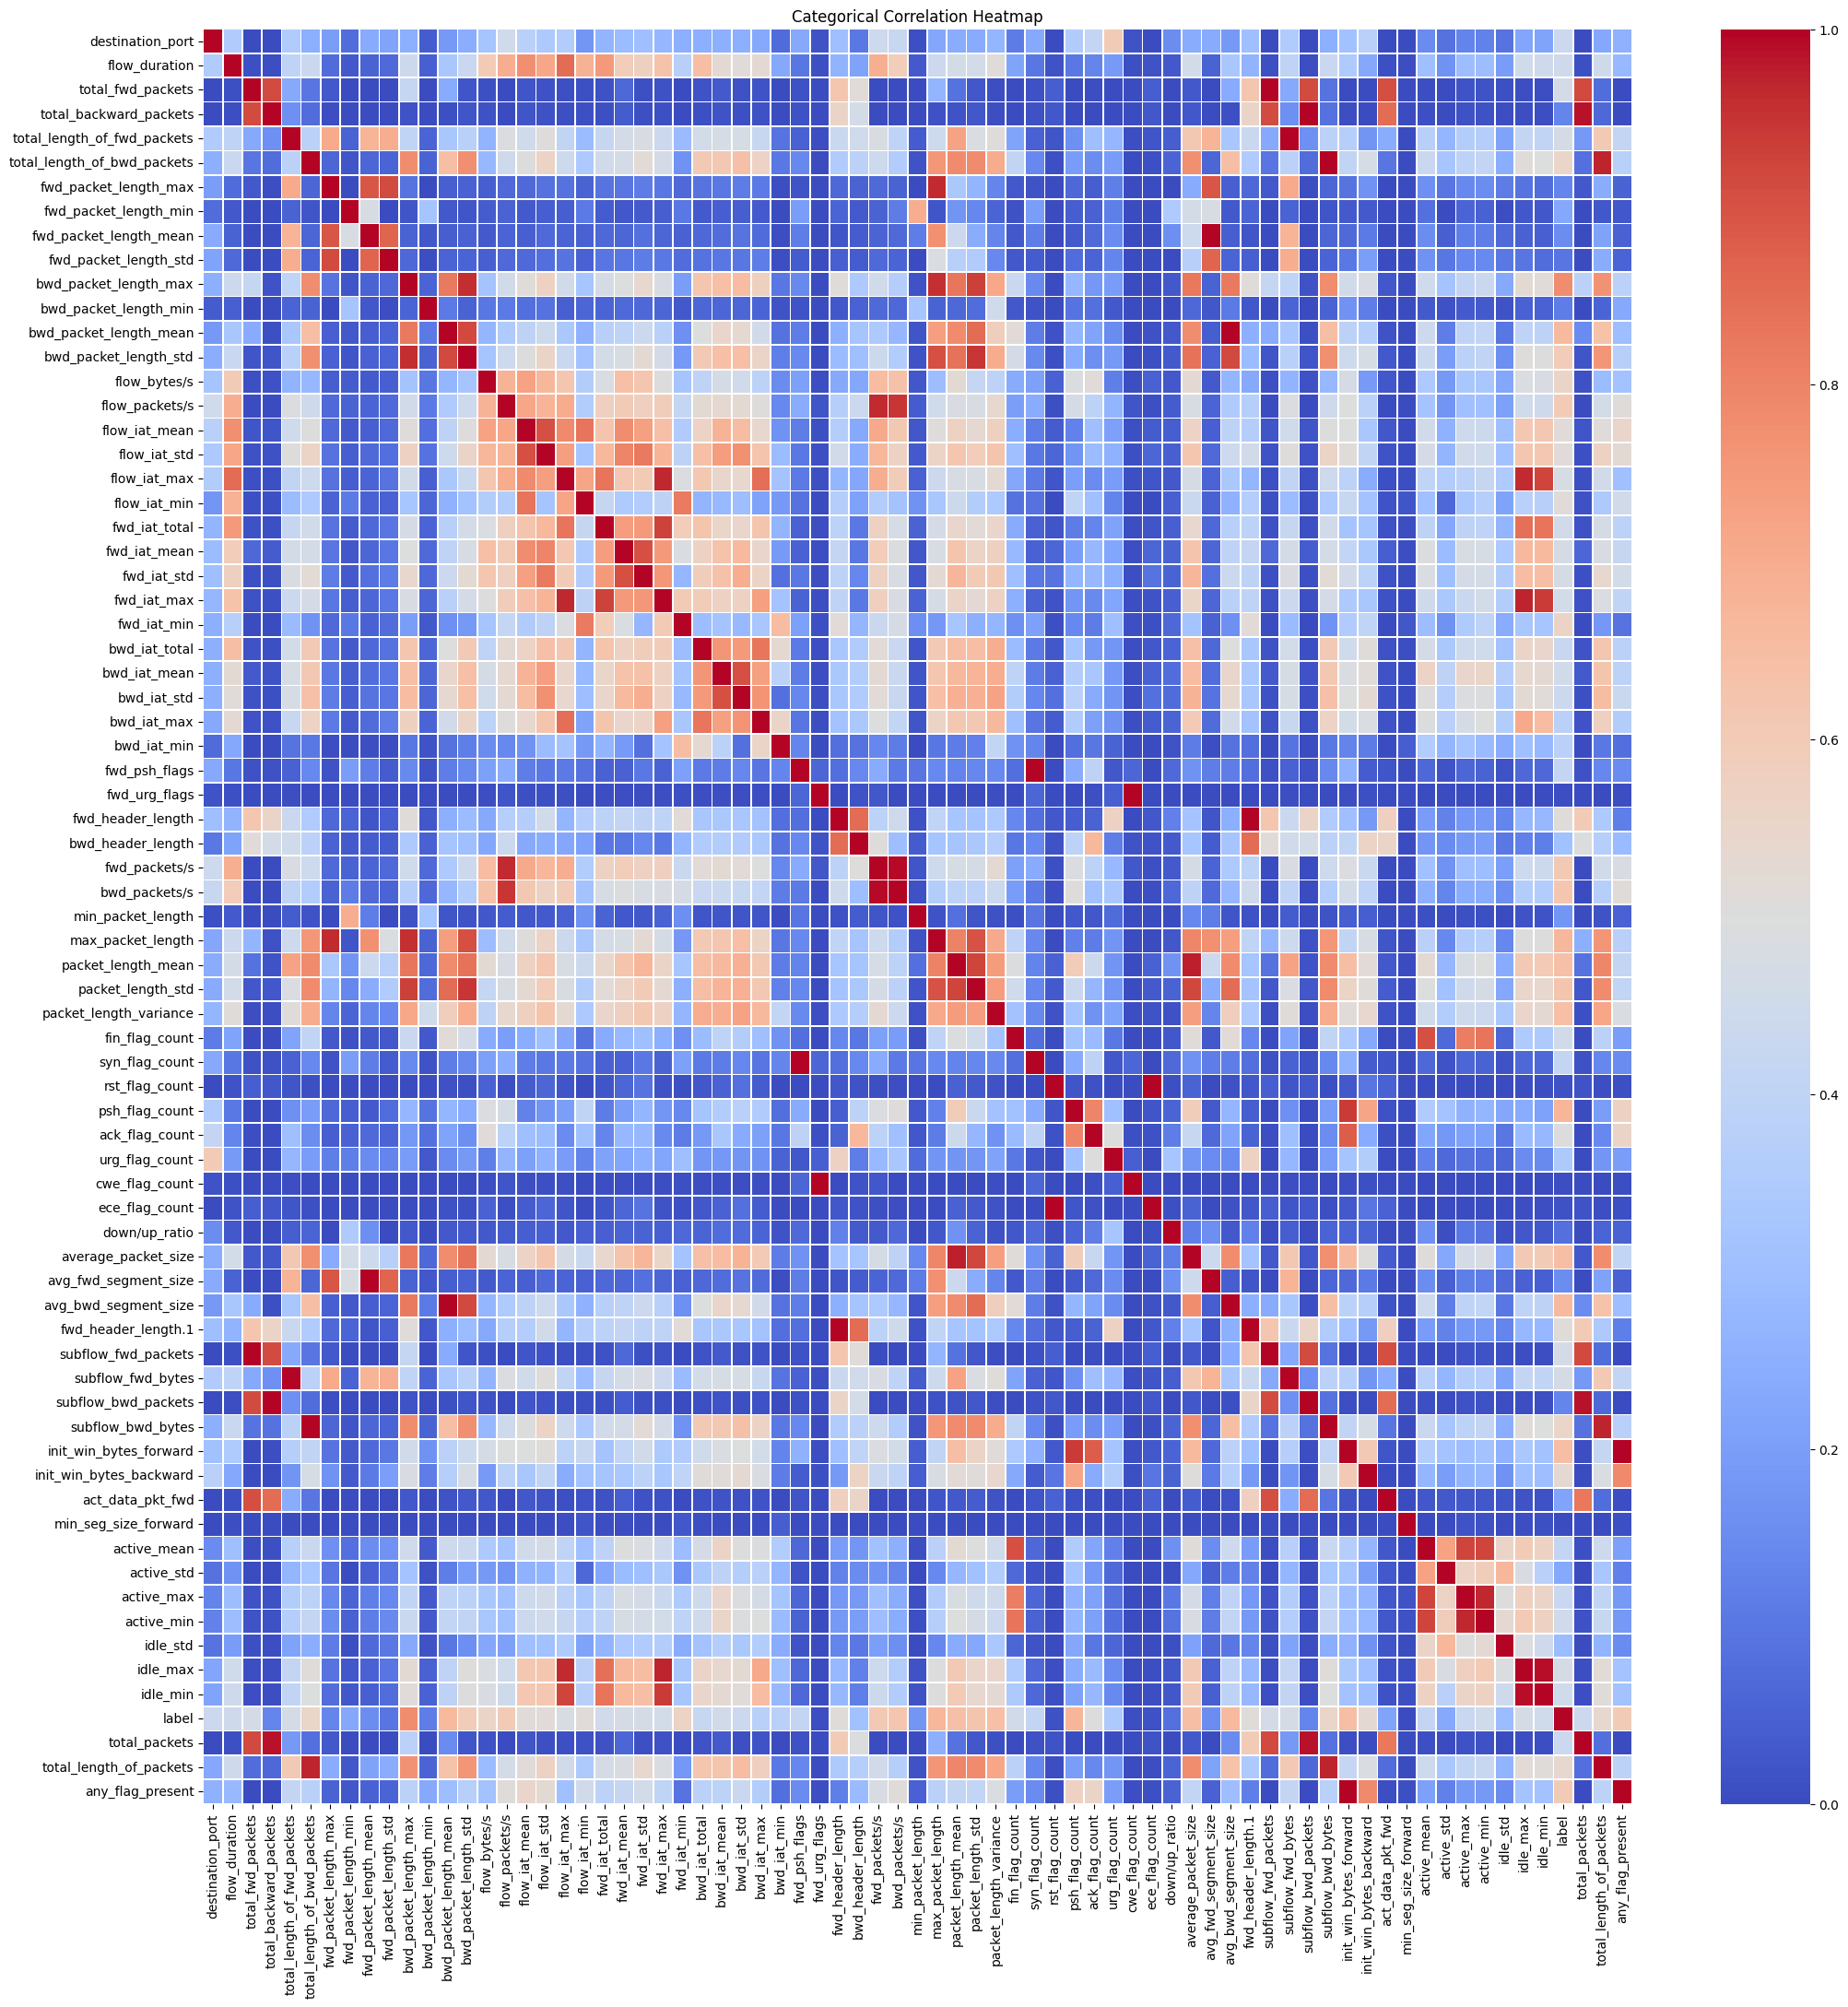

In [17]:
corr_df = df.phik_matrix()

plt.figure(
    figsize=(25, 25)
)

# Установка размера шрифта для признаков
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

sns.heatmap(corr_df, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Categorical Correlation Heatmap")
plt.show()

In [18]:
#correlation_matrix = df.corr()
#correlation_matrix

## Деление на выборки

In [19]:
features = df.drop(['label'], axis=1)
target = df['label']

In [20]:
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

In [21]:
np.unique(target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [22]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.25,
    stratify=target,
    random_state=42)

## Обучение моделей

In [23]:
catboost_model = CatBoostClassifier(loss_function='MultiClass', verbose=25, random_state=42)

param_grid = {
    'iterations': [300],
    'depth': [6, 8],
    'learning_rate': [0.01, 0.05],
}

grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=2, verbose=25)

grid_search.fit(features_train, target_train)

print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_

predictions = best_model.predict(features_test)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2; 1/4] START depth=6, iterations=300, learning_rate=0.01.................
0:	learn: 2.5877632	total: 723ms	remaining: 3m 36s
25:	learn: 1.3936248	total: 14.5s	remaining: 2m 33s
50:	learn: 0.9667810	total: 28.3s	remaining: 2m 18s
75:	learn: 0.7223231	total: 42s	remaining: 2m 3s
100:	learn: 0.5605705	total: 55.7s	remaining: 1m 49s
125:	learn: 0.4458493	total: 1m 10s	remaining: 1m 36s
150:	learn: 0.3610985	total: 1m 24s	remaining: 1m 23s
175:	learn: 0.2972582	total: 1m 38s	remaining: 1m 9s
200:	learn: 0.2482068	total: 1m 51s	remaining: 55.1s
225:	learn: 0.2093726	total: 2m 5s	remaining: 41.1s
250:	learn: 0.1790076	total: 2m 19s	remaining: 27.2s
275:	learn: 0.1547762	total: 2m 32s	remaining: 13.3s
299:	learn: 0.1354917	total: 2m 45s	remaining: 0us
[CV 1/2; 1/4] END depth=6, iterations=300, learning_rate=0.01;, score=0.983 total time= 2.8min
[CV 2/2; 1/4] START depth=6, iterations=300, learning_rate=0.01.................
0:	l

In [24]:
precision = precision_score(target_test, predictions, average='weighted')
recall = recall_score(target_test, predictions, average='weighted')
f1 = f1_score(target_test, predictions, average='weighted')
accuracy = accuracy_score(target_test, predictions)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Precision: 0.9975
Recall: 0.9973
F1 Score: 0.9969
Accuracy: 0.9973


In [25]:
target_names = list(df['label'].unique())

In [26]:
print(classification_report(target_test, predictions, target_names=target_names, zero_division = 0))

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     60000
                  PortScan       0.96      0.96      0.96       492
                  DoS Hulk       1.00      1.00      1.00     16091
                      DDoS       0.99      0.99      0.99      2573
                       Bot       1.00      1.00      1.00     28994
              Infiltration       1.00      0.99      1.00      1375
  Web Attack � Brute Force       1.00      1.00      1.00      1449
          Web Attack � XSS       1.00      1.00      1.00      1984
Web Attack � Sql Injection       1.00      1.00      1.00         3
               FTP-Patator       1.00      0.67      0.80         9
               SSH-Patator       1.00      1.00      1.00     19915
             DoS slowloris       1.00      0.99      1.00      1474
          DoS Slowhttptest       0.70      0.98      0.82       377
             DoS GoldenEye       0.00      0.00

Сохраним модель для дальнейшего ее использования во Flask и Docker.

In [27]:
best_model.save_model('best_catboost_model.bin')